In [101]:
# set global values
train_model=False

In [102]:
import logging 
logging.basicConfig(level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
logging.info("starting script")


from pathlib import Path
from logging import getLogger, Formatter, FileHandler, StreamHandler, INFO, DEBUG


def create_logger(exp_version):
    log_file = ("{}.log".format(exp_version))

    # logger
    logger_ = getLogger(exp_version)
    logger_.setLevel(DEBUG)

    # formatter
    fmr = Formatter("[%(levelname)s] %(asctime)s >>\t%(message)s")

    # file handler
    fh = FileHandler(log_file)
    fh.setLevel(DEBUG)
    fh.setFormatter(fmr)

    # stream handler
    ch = StreamHandler()
    ch.setLevel(INFO)
    ch.setFormatter(fmr)

    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger(exp_version):
    return getLogger(exp_version)

VERSION = "001" 
create_logger(VERSION)
get_logger(VERSION).info("top of script")

2024-12-05 15:36:27 - INFO - starting script
[INFO] 2024-12-05 15:36:27,677 >>	top of script
[INFO] 2024-12-05 15:36:27,677 >>	top of script
[INFO] 2024-12-05 15:36:27,677 >>	top of script
[INFO] 2024-12-05 15:36:27,677 >>	top of script
[INFO] 2024-12-05 15:36:27,677 >>	top of script
2024-12-05 15:36:27 - INFO - top of script


In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

files = []
data_dir = 'C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics'
miscon_file_index = 0
train_file_index = 3
test_file_index = 2
# on kaggle
# data_dir = '/kaggle/input'
#miscon_file_index = 1
#train_file_index = 2
#test_file_index = 3

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        get_logger(VERSION).info(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename))
print(files)
misconceptions_filename = files[miscon_file_index]
train_filename = files[train_file_index]
test_filename = files[test_file_index]

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[INFO] 2024-12-05 15:36:27,851 >>	C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\misconception_mapping.csv
[INFO] 2024-12-05 15:36:27,851 >>	C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\misconception_mapping.csv
[INFO] 2024-12-05 15:36:27,851 >>	C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\misconception_mapping.csv
[INFO] 2024-12-05 15:36:27,851 >>	C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\misconception_mapping.csv
[INFO] 2024-12-05 15:36:27,851 >>	C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\misconception_mapping.csv
2024-12-05 15:36:27 - INFO - C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\misconception_mapping.csv
[INFO] 2024-12-05 15:36:27,862 >>	C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\sample_submission.csv
[INFO] 2024-12-05 15:36:27,862 >>	C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathema

['C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\\misconception_mapping.csv', 'C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\\sample_submission.csv', 'C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\\test.csv', 'C:/ai_ml/kaggle/eedi-mining/eedi-mining-misconceptions-in-mathematics\\train.csv']


## File and Field Information
### [train/test].csv

* QuestionId - Unique question identifier (int).
* ConstructId - Unique construct identifier (int) .
* ConstructName - Most granular level of knowledge related to question (str).
* CorrectAnswer - A, B, C or D (char).
* SubjectId - Unique subject identifier (int).
* SubjectName - More general context than the construct (str).
* QuestionText - Question text extracted from the question image using human-in-the-loop OCR (str) .
* Answer[A/B/C/D]Text - Answer option A text extracted from the question image using human-in-the-loop OCR (str).
* Misconception[A/B/C/D]Id - Unique misconception identifier (int). Ground truth labels in train.csv; your task is to predict these labels for test.csv.

### misconception_mapping.csv
maps MisconceptionId to its MisconceptionName

### sample_submission.csv
A submission file in the correct format.
* QuestionId_Answer - Each question has three incorrect answers for which need you predict the MisconceptionId.
* MisconceptionId - You can predict up to 25 values, space delimited.


## Get training data

In [104]:
train_data = pd.read_csv(train_filename)
train_data_orig = train_data.copy()
train_data.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.0
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.0,143.0,2142.0,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.0,NaN,1287.0,1073.0
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.0,1180.0,NaN,1180.0
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.0


## Get test data

In [105]:
test_data = pd.read_csv(test_filename)
test_data_orig = test_data.copy()
test_data.head()
print ("test_data shape")
print("rows", test_data.shape[0])
print("columns",test_data.shape[1])

test_data shape
rows 3
columns 11


## Get misconception data


In [106]:
miscon_data = pd.read_csv(misconceptions_filename)
miscon_data.head()


,MisconceptionId,MisconceptionName
0,0,Does not know that angles in a triangle sum to...
1,1,Uses dividing fractions method for multiplying...
2,2,Believes there are 100 degrees in a full turn
3,3,Thinks a quadratic without a non variable term...
4,4,Believes addition of terms and powers of terms...


In [107]:
print ("miscon_data shape")
print("rows", miscon_data.shape[0])
print("columns",miscon_data.shape[1])

miscon_data shape
rows 2587
columns 2


In [108]:
subject_groups = train_data.groupby(["SubjectId","SubjectName"]).count().sort_values('QuestionId',ascending=False).reset_index()
print(subject_groups.shape[0], " different subject groups")
subject_groups.head()

163  different subject groups


,SubjectId,SubjectName,QuestionId,ConstructId,ConstructName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,64,Linear Equations,53,53,53,53,53,53,53,53,53,23,32,30,27
1,171,Linear Sequences (nth term),44,44,44,44,44,44,44,44,44,28,20,21,19
2,33,BIDMAS,37,37,37,37,37,37,37,37,37,20,21,23,24
3,65,Quadratic Equations,36,36,36,36,36,36,36,36,36,18,17,25,14
4,75,Area of Simple Shapes,36,36,36,36,36,36,36,36,36,22,26,23,24


In [109]:
print("percentages of null values")
pd.DataFrame({'Count':train_data.isnull().sum()[train_data.isnull().sum()>0],'Percentage':(train_data.isnull().sum()[train_data.isnull().sum()>0]/train_data.shape[0])*100})

percentages of null values


,Count,Percentage
MisconceptionAId,734,39.272338
MisconceptionBId,751,40.181915
MisconceptionCId,789,42.215088
MisconceptionDId,832,44.515784


## Clean up missing data

In [110]:
# records where more than one misconception id is missing
missing_a_misconception = train_data[(train_data.CorrectAnswer == "A") & (train_data.MisconceptionBId.isnull() | train_data.MisconceptionCId.isnull()  | train_data.MisconceptionDId.isnull()) ]
print(missing_a_misconception.shape)
missing_a_misconception.head()
train_data[(train_data.CorrectAnswer == "A")].shape

(244, 15)


(482, 15)

In [111]:
missing_b_misconpception = train_data[(train_data.CorrectAnswer == "B") & (train_data.MisconceptionAId.isnull() | train_data.MisconceptionCId.isnull()) ]
missing_b_misconpception.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
10,10,1414,Expand products of three binomials in the form...,335,Expanding Triple Brackets and more,B,John is expanding these three brackets:\n\(\n(...,\( +6 x^{2} \),\( \begin{array}{l}+6 x^{2} \\ -3 x^{2} \\ +5 ...,\( \begin{array}{l}+6 x^{2} \\ +3 x^{2} \\ +5 ...,\( \begin{array}{l}+6 x^{2} \\ -3 x^{2} \\ -5 ...,NaN,NaN,583.0,NaN
13,13,3065,Convert from hours to minutes,209,Time,B,Hannah's journey to camp is \( 3 \) hours and ...,\( 196 \) minutes,\( 18 \) minutes,\( 102 \) minutes,\( 12 \) minutes,NaN,NaN,161.0,NaN
18,18,261,Carry out missing number subtraction problems ...,211,Adding and Subtracting Negative Numbers,B,![Number line with -12 and -7 marked. Starting...,\( -7 \),\( -5 \),\( -2 \),\( -6 \),2179.0,NaN,NaN,1824.0
20,20,2306,"Given the volume of a cuboid, work out missing...",189,Volume of Prisms,B,The volume of this cuboid is \( 30 \mathrm{~cm...,\( 6 \mathrm{~cm} \),\( 5 \mathrm{~cm} \),\( 4 \mathrm{~cm} \),\( 25 \mathrm{~cm} \),NaN,NaN,NaN,1984.0
21,21,1434,Factorise a quadratic expression in the form a...,53,Factorising into a Double Bracket,B,Step 1: Factorise the following expression\n\n...,\( (3 x+2)(3 x+1) \),\( (3 x+2)(x+1) \),Cannot be factorised,\( (3 x+1)(x+2) \),2240.0,NaN,NaN,NaN


## Update data to prepare for creating vectors

In [112]:
# clean up question
# train_data['CleanQuestion'] = train_data['QuestionText'].replace('\n',' ',regex=True)

# create new data frame with just misconceptions
# Create a new empty DataFrame
miscon_model = pd.DataFrame()

In [113]:
"""
# convert latext formatting to text
from pylatexenc.latex2text import LatexNodes2Text
import pylatexenc
# Convert LaTeX to plain text
# Function to convert LaTeX to text
def latex_to_text(latex_string):
    return LatexNodes2Text().latex_to_text(latex_string)
"""

# repolace names with variables to get consistency on vectors
import spacy

# Load the spaCy model
# for running locally, need to do
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Function to replace all detected names with unique variables
def replace_names_with_variables(text):
    doc = nlp(text)
    name_counter = 1
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            var_name = f"NAME{name_counter}"
            text = text.replace(ent.text, var_name)
            name_counter += 1
    return text

#def clean_math_text(text):
    # clean_text = latex_to_text(text)
    # clean_text = replace_names_with_variables(clean_text)
    # remove new line and other characters
    # print('before',clean_text)
    #clean_text = clean_text.replace('\n',' ')
    # print('after', clean_text)
    
    #return clean_text 
import re

def clean_math_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters (keeping LaTeX symbols)
    text = text.replace("\\n", " ")
    text = re.sub(r'[^a-zA-Z0-9\s\\{}^_]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Example text
text = "Here's an example: \int_0^{\infty} e^{-x^2} dx.\n Let's clean it up!"

# Clean the text
cleaned_text = clean_math_text(text)
print(cleaned_text)


# remove special characters like new line
#miscon_model['subjectName'] = train_data.SubjectName
#miscon_model['constructName'] = train_data.ConstructName
#miscon_model['question'] = train_data['QuestionText'].apply(clean_math_text)
#  Creating the flattened DataFrame
import math
flattened_data = []
next_sentence =[]
next_sentence_val = []
pairs=[]
val_pairs = []
miscon_ids_used = {}
MAX_LEN=1400
def add_other_misconceptions_as_label_1(problem_and_wrong_answer, misconception_id_in):
    # dataframe of all misconception ids except this on
    all_but_one = miscon_data[miscon_data['MisconceptionId'] != misconception_id_in]
    all_but_one = all_but_one.sample(n=50, replace=True, random_state=1)
    for index0, row0 in all_but_one.iterrows():
        #print("row0",row0.MisconceptionName)
        next_sentence.append({'problem_and_wrong_answer': problem_and_wrong_answer,"misconception_text": row0.MisconceptionName, "misconception_id": row0.MisconceptionId,"label":1})

for index, row in train_data.iterrows():
    # put incorrect answer A into row
    # print ("a id",row.MisconceptionAId)

    if ((row.CorrectAnswer != "A") & (math.isnan(row.MisconceptionAId) == False)):
        misconception_text_row = miscon_data[(miscon_data.MisconceptionId==row.MisconceptionAId)]
        #print(type(misconception_text_row))
        #print(misconception_text_row.iloc[0,1])
        misconception_id = row.MisconceptionAId
        formatted_answer = clean_math_text(row['AnswerAText'])
        #flattened_data.append({'subjectName': row['SubjectName'], 'constructName': row['ConstructName'], 'latex_formatted_question': row['QuestionText'], 'question': clean_math_text(row['QuestionText']), 'latex_formatted_wrongAnswer': row['AnswerAText'], 'wrongAnswer': clean_math_text(row['AnswerAText']), 'misconception': misconception_row.MisconceptionName})
    if ((row.CorrectAnswer != "B") & (math.isnan(row.MisconceptionBId)==False)):
        misconception_text_row = miscon_data[(miscon_data.MisconceptionId==row.MisconceptionBId)]
        misconception_id = row.MisconceptionBId
        formatted_answer= clean_math_text(row['AnswerBText'])
        # flattened_data.append({'subjectName': row['SubjectName']}, 'constructName': row['ConstructName'], 'latex_formatted_question': row['QuestionText'], 'question': clean_math_text(row['QuestionText']), 'latext_formatted_wrongAnswer': row['AnswerBText'], 'wrongAnswer': clean_math_text(row['AnswerBText']), 'misconception': misconception_row.MisconceptionName})
    if ((row.CorrectAnswer != "C") & (math.isnan(row.MisconceptionCId) ==False)):
        misconception_text_row = miscon_data[(miscon_data.MisconceptionId==row.MisconceptionCId)]
        misconception_id = row.MisconceptionCId
        formatted_answer = clean_math_text(row['AnswerCText'])        
        # flattened_data.append({'subjectName': row['SubjectName'], 'constructName': row['ConstructName'], 'latex_formatted_question': row['QuestionText'], 'question': clean_math_text(row['QuestionText']), 'latext_formatted_wrongAnswer': row['AnswerCText'], 'wrongAnswer': clean_math_text(row['AnswerCText']), 'misconception': misconception_row.MisconceptionName})
    if ((row.CorrectAnswer != "D") & (math.isnan(row.MisconceptionDId) == False)):
        misconception_text_row = miscon_data[(miscon_data.MisconceptionId==row.MisconceptionDId)]
        misconception_id = row.MisconceptionDId
        formatted_answer =  clean_math_text(row['AnswerDText'])
        # flattened_data.append({'subjectName': row['SubjectName'], 'constructName': row['ConstructName'], 'latex_formatted_question': row['QuestionText'], 'question': clean_math_text(row['QuestionText']), 'latext_formatted_wrongAnswer': row['AnswerDText'], 'wrongAnswer': clean_math_text(row['AnswerDText']), 'misconception': misconception_row.MisconceptionName})
    problem_and_wrong_answer = f"{clean_math_text(row['ConstructName'])} {clean_math_text(row['QuestionText'])} {formatted_answer}"
    misconception_text= misconception_text_row.iloc[0,1]
    qa_pairs = []
    qa_pairs.append(' '.join(problem_and_wrong_answer.split()[:MAX_LEN]))
    qa_pairs.append(' '.join(misconception_text.split()[:MAX_LEN]))
    if (index < 10):
        print(qa_pairs)
    
    misconception_id = misconception_text_row.iloc[0,0]
    if misconception_id in miscon_ids_used:
        miscon_ids_used[misconception_id] += 1
    else:
        miscon_ids_used[misconception_id] = 1
    if (miscon_ids_used[misconception_id] <= 2):
        pairs.append(qa_pairs)
    else:
        val_pairs.append(qa_pairs)

    flattened_data.append({'text': f"{clean_math_text(row['SubjectName'])} {clean_math_text(row['ConstructName'])} {clean_math_text(row['QuestionText'])} {formatted_answer}", "label": int(misconception_id)})
    
    next_sentence.append({'problem_and_wrong_answer': problem_and_wrong_answer,"misconception_text": misconception_text_row.iloc[0,1], "misconception_id": misconception_text_row.iloc[0,0],"label":0})
    #add_other_misconceptions_as_label_1(problem_and_wrong_answer, misconception_id)
flattened_df = pd.DataFrame(flattened_data)
# Sort by the 'label' column in ascending order 
flattened_df = flattened_df.sort_values(by='label')
flattened_df = flattened_df.reset_index(drop = True)

next_sentence_df = pd.DataFrame(next_sentence)
next_sentence_df['qlength'] = next_sentence_df['problem_and_wrong_answer'].str.len()
next_sentence_df['mlength'] = next_sentence_df['misconception_text'].str.len()


<>:52: SyntaxWarning: invalid escape sequence '\i'
<>:52: SyntaxWarning: invalid escape sequence '\i'
C:\Users\billl\AppData\Local\Temp\ipykernel_10504\1767391032.py:52: SyntaxWarning: invalid escape sequence '\i'
  text = "Here's an example: \int_0^{\infty} e^{-x^2} dx.\n Let's clean it up!"


heres an example \int_0^{\infty} e^{x^2} dx lets clean it up
['use the order of operations to carry out calculations involving powers \\ 3 \\times 245 \\ where do the brackets need to go to make the answer equal \\ 13 \\ does not need brackets', 'Confuses the order of operations, believes addition comes before multiplication']
['simplify an algebraic fraction by factorising the numerator simplify the following if possible \\ \\frac{m^{2}2 m3}{m3} \\ \\ m1 \\', 'Does not know that to factorise a quadratic expression, to find two numbers that add to give the coefficient of the x term, and multiply to give the non variable term']
['calculate the range from a list of data tom and katie are discussing the \\ 5 \\ plants with these heights \\ 24 \\mathrm{cm} 17 \\mathrm{cm} 42 \\mathrm{cm} 26 \\mathrm{cm} 13 \\mathrm{cm} \\ tom says if all the plants were cut in half the range wouldnt change katie says if all the plants grew by \\ 3 \\mathrm{cm} \\ each the range wouldnt change who do you ag

In [114]:
flattened_df.head()

,text,label
0,angles in triangles find missing angles in a s...,0
1,measuring angles identify the number of degree...,2
2,factorising into a single bracket factorise a ...,3
3,simplifying expressions by collecting like ter...,4
4,simplifying expressions by collecting like ter...,4


In [115]:
print(next_sentence_df.shape)

next_sentence_df.head()

(1869, 6)


,problem_and_wrong_answer,misconception_text,misconception_id,label,qlength,mlength
0,use the order of operations to carry out calcu...,"Confuses the order of operations, believes add...",1672,0,175,80
1,simplify an algebraic fraction by factorising ...,Does not know that to factorise a quadratic ex...,2142,0,126,167
2,calculate the range from a list of data tom an...,Believes if you add the same value to all numb...,1073,0,378,86
3,recall and use the intersecting diagonals prop...,Does not know the properties of a rectangle,1180,0,348,43
4,substitute positive integer values into formul...,Thinks you can find missing values in a given ...,1818,0,324,146


In [116]:
len(pairs)

1406

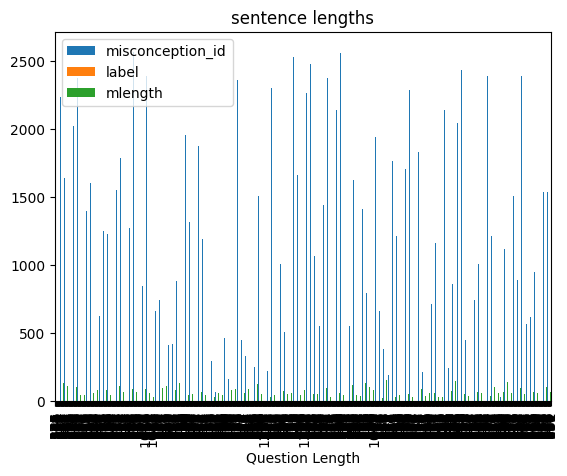

In [117]:
import matplotlib.pyplot as plt
next_sentence_df.plot(x='qlength', kind='bar')
plt.title('sentence lengths')
plt.xlabel('Question Length')

plt.show()

In [118]:
sentence_a = []
sentence_b = []
sentence_label = []
max_sentence_length = 0
max_question = ''
max_misconception = ''
for index, row in next_sentence_df.iterrows():
    if (len(row['problem_and_wrong_answer']) > max_sentence_length):
        max_sentence_length = len(row['problem_and_wrong_answer'])
        max_question = row['problem_and_wrong_answer']
    sentence_a.append(row['problem_and_wrong_answer'])
    misconception_id = row['misconception_id']
    if (len(row['misconception_text']) > max_sentence_length):
        max_sentence_length = len(row['misconception_text'])
        max_misconception = row['misconception_text']
    sentence_b.append(row['misconception_text'])
    sentence_label.append(row['label'])
    #print(f"Index: {index}, problem_and_wrong_answer: {row['problem_and_wrong_answer']}")

print("max sentence length", max_sentence_length)
print('max question', max_question)
print('max misconception', max_misconception)

max sentence length 1353
max question use a linear sequence expressed as a pattern to make a prediction about another term in the sequence other than the next one tom and katie are discussing this sequence the first 3 patterns in a sequence are shown the first pattern is a blue rectangle with 6 yellow circles attached to its perimeter 2 circles on each of the longer sides and 1 circle on each of the shorter sides pattern 2 is made up of 2 blue rectangles attached together in a row by their short edges there are also 10 yellow circles in this pattern attached to the perimeter of the rectangles 2 circles on every longer side of each rectangle and 1 circle on each of the two free shorter sides ie that are not attached to the other rectangle pattern 3 is made up of 3 blue rectangles attached together in a row by their short edges there are also 14 yellow circles in this pattern attached to the perimeter of the rectangles 2 circles on every longer side of each rectangle and 1 circle on each

From https://towardsdatascience.com/how-to-fine-tune-bert-with-nsp-8b5615468e12

From https://keras.io/examples/nlp/pretraining_BERT/

In [119]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam


In [120]:
TOKENIZER_BATCH_SIZE = 256  # Batch-size to train the tokenizer on
TOKENIZER_VOCABULARY = 25000  # Total number of unique subwords the tokenizer can have

BLOCK_SIZE = 128  # Maximum number of tokens in an input sample
NSP_PROB = 0.50  # Probability that the next sentence is the actual next sentence in NSP
SHORT_SEQ_PROB = 0.1  # Probability of generating shorter sequences to minimize the mismatch between pretraining and fine-tuning.
MAX_LENGTH = 512  # Maximum number of tokens in an input sample after padding

MLM_PROB = 0.2  # Probability with which tokens are masked in MLM

TRAIN_BATCH_SIZE = 2  # Batch-size for pretraining the model on
MAX_EPOCHS = 1  # Maximum number of epochs to train the model for
LEARNING_RATE = 1e-4  # Learning rate for training the model

MODEL_CHECKPOINT = "bert-base-cased"  # Name of pretrained model from 🤗 Model Hub

We are importing a pre-trained BERT tokenizer and a BERT model with an MLM head from the Hugging Face repository.



In [121]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertForMaskedLM.from_pretrained('bert-base-uncased')
#model = AutoModel.from_pretrained("google-bert/bert-base-cased")

As we can see, the Wordpiece tokenizer used for fine-tuning is BertTokenizer. The model used is TFBertForMaskedLM, a BERT model with an MLM head that can accept only Tensorflow tensors. In both of them, the check-point used is bert-base-uncased. Let’s look at the model summary:

In [122]:
#model.parameters()

https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891

## WordPiece Tokenization

The initial stage of creating a fresh BERT model involves training a new tokenizer. Tokenization is the process of breaking down a text into smaller units called “tokens,” which are then converted into a numerical representation. An example of this would be splitting the sentence

 “I like surfboarding!” → [‘[CLS]’, ‘i’, ‘like’, ‘surf’, ‘##board’, ‘##ing’, ‘!’, ‘[SEP]’] → [1, 48, 250, 4033, 3588, 154, 5, 2]
A tokenized BERT input always starts with a special [CLS] token and ends with a special [SEP] token, which are used for specific purposes that will be explained later. BERT employs a WordPiece tokenizer, which can split a single word into multiple tokens. For instance, in the example given earlier, the word “surfboarding” is broken down into ['surf', '##boarding', '##ing']. This technique helps the model to understand that words like surfboardand snowboardhave shared meaning through the common wordpiece ##board. By referring to the explanation from HuggingFace, WordPiece computes a score for each pair, using the following

score = (freq_of_pair) / (freq_of_first_element × freq_of_second_element)

By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary. For instance, it won’t necessarily merge ("un", "##able") even if that pair occurs very frequently in the vocabulary, because the two pairs "un" and "##able" will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like ("hu", "##gging") will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since "hu" and "##gging" are likely to be less frequent individually.

To train the tokenizer, the BertWordPieceTokenizer from the transformer library was used with the steps below:

1. Saving the conversation text into multiple .txt files (with batch of N=10000)
2. Define BertWordPieceTokenizer with some parameters likeclean_text to remove control characters, handle_chinese_chars to include spaces around Chinese characters, stripe_accents to remove accents and make é → e, ô → o, andlowercase to view capital and lowercase characters as equal.
3. Train the tokenizer based on the file path to .txt files with parameters like vocab_size defines the total number of tokens, min_frequency for minimum frequency for a pair of tokens to be merged, special_tokens defines a list of the special tokens that BERT uses, limit_alphabet for a maximum number of different characters, workpieces_prefix the prefix added to pieces of words (like ##ing).

In [123]:
# WordPiece tokenizer
import tqdm
from tokenizers import BertWordPieceTokenizer
### save data as txt file
data_dir = './data'
if os.path.isdir(data_dir):
    print('directory exists',data_dir)
else:
    os.mkdir(data_dir)
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train( 
    files=paths,
    vocab_size=30_000, 
    min_frequency=5,
    limit_alphabet=1000, 
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

bert_it_dir = './bert-it-1'
if os.path.isdir(bert_it_dir):
    print('directory exists',bert_it_dir)
else:
    os.mkdir(bert_it_dir)

tokenizer.save_model(bert_it_dir, 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)


directory exists ./data


100%|██████████| 1406/1406 [00:00<00:00, 468849.69it/s]

directory exists ./bert-it-1



C:\Users\billl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [124]:
import random
import datasets
from torch.utils.data import Dataset, DataLoader
import itertools
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]


In [125]:
max_seq_len = 128
train_data = BERTDataset(
   pairs, seq_len=max_seq_len, tokenizer=tokenizer)
print(len(train_data))
train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
print(train_data[random.randrange(len(train_data))])

1406
{'bert_input': tensor([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4,
        4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 2, 4, 4, 4, 4,
        4, 4, 4, 4, 3, 3, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'bert_label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0,
        0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'segment_label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 

## Embedding
The embedding in BERT comprises of three parts, mainly the token embeddings, segment embeddings and position embeddings.


In NLP model, the order of the words and their position in a sentence matters and the meaning of the entire sentence can change if the words are re-ordered. As such, transformer model did a position embedding for each token in the input using the formula


where

  - k: Position of an object in input sequence, 0 < k < L/2
  - d: Dimension of the output embedding space
  - n: User defined scalar. Default by 10,000
  - i: Used for mapping to column indices 0 < i < d/2. A single value of i maps to both sine and cosine functions

For all three different type of embeddings, they must be in the similar output size (768 in this case), so that all three of them can be summed together to be a single embedded output. You may notice thepadding_idx is specified as 0, this is to make pad token remains as 0 and not being updated during training.

In [126]:
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):   
            # for each dimension of the each position
            for i in range(0, d_model, 2):   
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)   
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=max_seq_len, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)
       
    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)


## Multi Head Attention
A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The code snippet for Multi-head attention might looks complicated at first sight, but it is just a simple translation from the equation below

$
Z = Softmax(\frac{QK^T}{\sqrt{d_k}})V
$

where Q, K, V are identical and linear transformation of input embeddings. The one thing that need more attention is the shape of input tensor, therefore, .permute() function is applied to amend the shape of tensor to fulfil the requirement for dot product.

### The details of the class MultiHeadedAttention

* It’s called multi-head attention because the hidden size: d_model(768) is split by heads(12), this allows the model to jointly attend to information at different positions from different representational spaces.
* It takes the query, key, and value as inputs, and the size is permuted from (batch_size, max_len, hidden_size) → (batch_size, num_heads, max_len, hidden_size / num_heads ). This indicates that all the 3 inpurs are linearly projected from the d_model dimensional space to heads sets of d_k dimensional vectors.
* Attention score matrix is computed using matrix multiplication between the query(Q) and key(K) tensors, followed by scaling by the square root of the key tensor’s dimension
* The mask is applied to the attention matrix and filled with -1e9 (close to negative infinity). This is done because the large negative inputs to softmax are near zero in the output.
* The final output is a weighted sum of the value(V) tensors, where the weights are determined by the softmax of the scaled dot-product between the query and key vectors.

### The EncoderLayer class contains 2 sublayers:.

* MultiHeadedAttention: A multi-headed self-attention module that computes the attention weights between each element in the input sequence
* FeedForward: A feedforward network with one hidden layer that applies a non-linear activation function (GELU) to the output of the first linear layer and produces a d_model dimensional output.

Each of these sublayers has a residual connection around it followed by a layer normalization LayerNorm(x + Sublayer(x)). Residual connections help in avoiding the vanishing gradient problem in deep networks.

In [127]:
### attention layers
class MultiHeadedAttention(torch.nn.Module):
    
    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)    

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)           
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        
        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self, 
        d_model=768,
        heads=12, 
        feed_forward_hidden=768 * 4, 
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

## Final BERT Model
Coming next, we are going to incorporate the encoder layer with attention mechanism into the final BERT’s construction.

1. The BERT class initializes the embedding layer for the input sequence, as well as multi layers of EncoderLayer blocks. The forward method of this class takes in the input sequence and a segment info tensor, applies attention masking to the input(for padded token), embeds the input sequence, and then passes it through the encoder blocks to obtain the output.
2. The NextSentencePrediction class is a 2-class classification model that takes in the output of the BERT class and predicts whether the input sequence contains two consecutive sentences or not. The forward method applies applies linear transformation and log softmax function to obtain the predicted probabilities of the two classes.
3. The MaskedLanguageModel class is a multi-class classification model that takes in the output of the BERT class and predicts the original tokens for the masked input sequence. The forward method applies a linear transformation and log softmax function to obtain the predicted probabilities of each token in the vocabulary.
4. The BERTLM class combines the BERT, NextSentencePrediction, and MaskedLanguageModel classes to create a complete BERT language model.


In [128]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4 * hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)


Optimizer
The original BERT model was trained using Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

$
lrate = d^{-0.5}_{model} * min(step\_num^{-0.5},step\_num * warmup\_steps^{-1.5})
$

In [129]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## Trainer
We came a long way to finally combine what we have discussed above and start training a new BERT model.

The BERTTrainerclass contains train() and test() methods that call the iteration() method to iterate over the given dataloader (train or test) for a specified epoch. The iteration() method calculates the loss and accuracy of the model on the given data and updates the parameters using backpropagation and optimization. It also logs the progress of training with a progress bar and prints the average loss and accuracy at the end of each epoch. Finally, we can do a test run for the BERT model on the processed data with low number of epochs count.

In [130]:
class BERTTrainer:
    
    def __init__(
        self, 
        model, 
        train_dataloader, 
        test_dataloader=None, 
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        
        ):
        self.losses = []
        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def get_losses (self):
        return self.losses
    
    def iteration(self, epoch, data_loader, train=True):
        
        avg_loss = 0.0
        total_correct = 0
        total_element = 0
        
        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }
            self.losses.append(post_fix)
            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )

In [131]:
'''training run'''

train_data = BERTDataset(
   pairs, seq_len=max_seq_len, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

val_data = BERTDataset(
   val_pairs, seq_len=max_seq_len, tokenizer=tokenizer)

val_loader = DataLoader(
   val_data, batch_size=32, shuffle=True, pin_memory=True)



bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
outputs = []
bert_trainer = BERTTrainer(model=bert_lm, train_dataloader=train_loader, test_dataloader=val_loader, device='cpu')
# do just one epic so we can get the flow of getting parameters, running training and validation and graphing loss
epochs = 10

if (train_model): 
   for epoch in range(epochs):
      bert_trainer.train(epoch)

bert_trainer.model.parameters()

Total Parameters: 14184199


<generator object Module.parameters at 0x000002BFE1B702E0>

## Validation

In [132]:
print(bert_trainer)

if (train_model):
  for epoch in range(epochs):
    bert_trainer.test(epoch)


print('\n\nModel params:')

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in bert_model.state_dict():
    print(param_tensor, "\t", bert_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in bert_trainer.optim.state_dict():
    print(var_name, "\t", bert_trainer.optim.state_dict()[var_name])





Model params:
Model's state_dict:
embedding.token.weight 	 torch.Size([5, 768])
embedding.segment.weight 	 torch.Size([3, 768])
encoder_blocks.0.layernorm.weight 	 torch.Size([768])
encoder_blocks.0.layernorm.bias 	 torch.Size([768])
encoder_blocks.0.self_multihead.query.weight 	 torch.Size([768, 768])
encoder_blocks.0.self_multihead.query.bias 	 torch.Size([768])
encoder_blocks.0.self_multihead.key.weight 	 torch.Size([768, 768])
encoder_blocks.0.self_multihead.key.bias 	 torch.Size([768])
encoder_blocks.0.self_multihead.value.weight 	 torch.Size([768, 768])
encoder_blocks.0.self_multihead.value.bias 	 torch.Size([768])
encoder_blocks.0.self_multihead.output_linear.weight 	 torch.Size([768, 768])
encoder_blocks.0.self_multihead.output_linear.bias 	 torch.Size([768])
encoder_blocks.0.feed_forward.fc1.weight 	 torch.Size([3072, 768])
encoder_blocks.0.feed_forward.fc1.bias 	 torch.Size([3072])
encoder_blocks.0.feed_forward.fc2.weight 	 torch.Size([768, 3072])
encoder_blocks.0.feed_forw

## Save Model

In [133]:
if (train_model):
    torch.save(bert_lm,'eedi_mining_bert.pth')
    torch.save(bert_lm.state_dict(), 'eedi_mining_bert_dict.pth')

## Load model and use

In [135]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = torch.load('eedi_mining_bert.pth')
# AutoModelForSequenceClassification.from_pretrained('path/to/checkpoint')
bert_lm.next_sentence()

C:\Users\billl\AppData\Local\Temp\ipykernel_10504\2544680678.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('eedi_mining_bert.pth')


TypeError: NextSentencePrediction.forward() missing 1 required positional argument: 'x'